In [1]:
ls ../dnftresult

DoubleDat_CNN_baseline_images/
DoubleDat_Plambda_image_RotMaskFeat1Reslayer_baseline_images/
DoubleDat_Plambda_image_RotMaskFeat1layer_baseline_images/
DoubleDat_Plambda_image_RotMaskFeat2Reslayer_baseline_images/
DoubleDat_Plambda_image_RotMaskFeat2layer_baseline_images/
DoubleDat_Plambda_image_RotMaskFeat2layer_ver2_baseline_images/
DoubleDat_Plambda_image_RotMaskFeat2layer_ver3_baseline_images/
DoubleDat_Plambda_image_RotMaskFeatCNN1layer_baseline_images/
OneDCyclic_fordebug_baseline/
OneDCyclic_mlp1layer_nonDim_baseline/
OneDsignal_OddEvenTwo_ForOwnDecoder_trial_baseline/
OneDsignal_OddEvenTwo_OneLayer_lasso_baseline/
OneDsignal_OddEvenTwo_Trial_OwnDecoderTwo_baseline/
OneDsignal_OddEvenTwo_Trial_OwnDecoder_baseline/
OneDsignal_OddEvenTwo_Trial_OwnDecoder_sparse_baseline/
OneDsignal_OddEvenTwo_Trial_OwnDecoder_sparse_two_baseline/
OneDsignal_OddEven_ForOwnDecoder_trial_baseline/
OneDsignal_OddEven_ForOwnDecoder_trial_slower/
OneDsignal_OddEven_OneLayer_lasso_baseline/
OneDsignal_Od

In [2]:
"OneDsignal_c8mimic_lowpow"
"Plambda_OneD_RotMaskFeat2layer"
"faster"

'faster'

./dataset/oneDsignal_data.py
[0, 2, 4, 8, 16, 32]
0


100%|██████████| 33/33 [00:02<00:00, 11.48it/s]


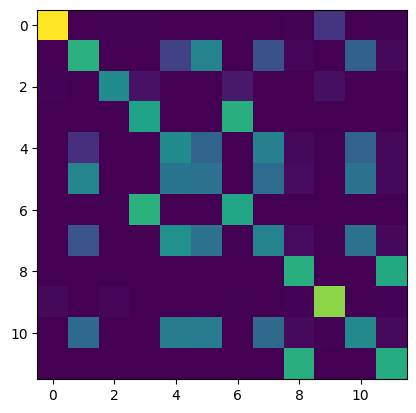

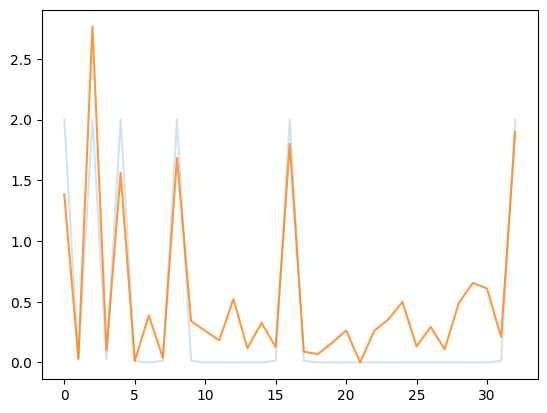

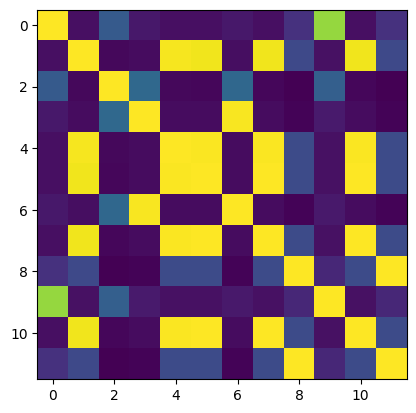

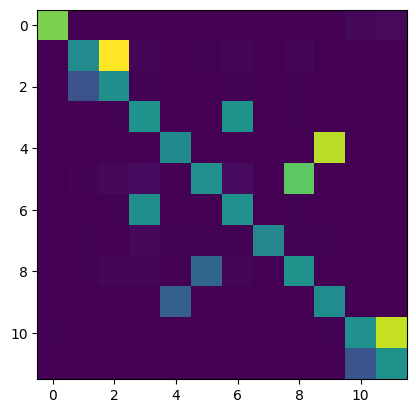

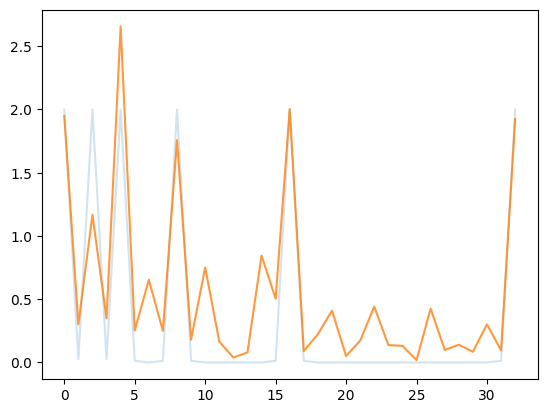

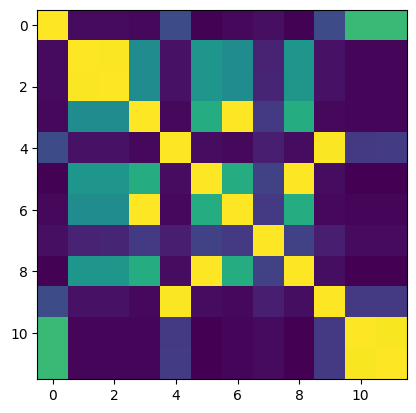

In [180]:
import sys
import yaml

sys.path.append("../")
import os
import torch
from misc import yaml_util as yu
import numpy as np

sys.path.append("../dataset")
sys.path.append("../module")
sys.path.append("../misc")

from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from misc import character_analysis as ca
from misc import loss_helper as lh
import pdb
import copy
from module import ft_decimation as ftd

import time


datname = "OneDsignal_c8mimic_lowpow"
modelname = "Plambda_OneD_RotMaskFeat2layer_debug"
trainname = "faster"


# datname = "OneDsignal_highlow8m"
# modelname = "Plambda_OneD_RotMaskFeat2layer_debug"
# trainname = "long_hor"


with open(f"""../cfg_data/{datname}.yaml""", "rb") as f:
    cfg_data = yaml.safe_load(f)

cfg_data["args"]["shift_label"] = True
mydata = yu.load_component(cfg_data)

expname = f"""{datname}_{modelname}_{trainname}"""

exppath = os.path.join("../dnftresult", expname)

mymodelpath = f"""{exppath}/model.pt"""
mymodel = torch.load(mymodelpath)


myloader = DataLoader(
    mydata,
    batch_size=32,
    shuffle=True,
    num_workers=2,
)


Ms = {0: [], 1: []}
DMs =  {0: None, 1: None}
OMs =  {0: None, 1: None}

for to_take_a_look in Ms.keys():
    
    if hasattr(mymodel, "nftlayers"):
        mynft = mymodel.nftlayers[to_take_a_look]
    else:
        mynft = mymodel


    shifts = []
    DMs[to_take_a_look] = mynft.PLambdaNet.dynamics_mask
    OMs[to_take_a_look] = mynft.PLambdaNet.own_mask


    
    if hasattr(mydata, "nfreq"):
        for k in range(20):
            evalseq, shift = next(iter(myloader))
            evalseq = evalseq[:, :2].to(mynft.encoder.device)
            predicted = mymodel(evalseq, n_rolls=1)
            shifts.append(shift)
            Ms[to_take_a_look].append(mynft.dynamics.M)
    
        shifts = torch.concatenate(shifts)
        Ms[to_take_a_look] = torch.concatenate(Ms[to_take_a_look]).detach()
    
        plt.figure()
    
        matrixMeanshape = torch.mean(torch.abs(Ms[to_take_a_look].detach()).to("cpu"), axis=0)
    
        plt.imshow(matrixMeanshape)
    
        myfreqs = np.array(mydata.freqsel)
        maxfreq = np.max(myfreqs)
    
        targfreq, prods0 = ca.inner_prod(
            Ms[to_take_a_look].to(shifts.device), shifts, maxfreq=maxfreq, bins=maxfreq + 1
        )
    
        plt.figure()
        deltas = ca.deltafxn(targfreq, mydata.freqsel) * 2
        plt.plot(
            targfreq,
            deltas,
            alpha=0.2,
            label="gt:" + str(np.where(deltas > 1.0)[0]),
        )
        targfreq, prods0 = ca.inner_prod(
            Ms[to_take_a_look].to(shifts.device), shifts, maxfreq=maxfreq, bins=maxfreq + 1
        )
        plt.plot(
            targfreq,
            prods0,
            label="pred0:" + str(np.where(prods0 > 1.0)[0]),
            alpha=0.8,
        )

        plt.figure()
        plt.imshow(DMs[to_take_a_look].detach().to('cpu')) 
    


In [181]:
import torch

# Function to find connected components based on non-zero entries
def find_connected_components(matrix, threshold = 0.1):
    n = matrix.size(0)
    visited = [False] * n
    components = []
    
    
    def dfs(i, component):
        visited[i] = True
        component.append(i)
        for j in range(n):
            if torch.abs(matrix[i, j]) > threshold or torch.abs(matrix[j, i]) >  threshold:  # Check for non-zero connections
                if not visited[j]:
                    dfs(j, component)

    for i in range(n):
        if not visited[i]:
            component = []
            dfs(i, component)
            components.append(component)

    return components

# def extractor(matrix, idx): 
#     filtered = torch.zeros_like(matrix)
#     filtered[idx][:, idx] = matrix[idx][:, idx]
    
#     return filtered

def extractor(matrix, idx): 
    # Create a zero matrix of the same size
    filtered = torch.zeros_like(matrix)
    
    # Use advanced indexing to assign the submatrix from matrix to filtered
    for i in range(len(idx)):
        for j in range(len(idx)):
            filtered[idx[i], idx[j]] = matrix[idx[i], idx[j]]
    
    return filtered

def batch_extractor(matrices, idx): 
    filtered = torch.zeros_like(matrices)
    for j in range(len(matrices)):
        filtered[j] = extractor(matrices[j], idx)
    return filtered

In [182]:
find_connected_components(DMs[0], threshold=0.4) 

[[0, 9], [1, 4, 5, 7, 10], [2], [3, 6], [8, 11]]

In [183]:
find_connected_components(DMs[1], threshold=0.4) 

[[0, 10, 11], [1, 2, 3, 5, 6, 8], [4, 9], [7]]

In [184]:
MsMean = [None] * len(Ms) 
for k in range(len(Ms)):
    MsMean[k] = torch.mean(torch.abs(Ms[k]), dim=0).detach().to('cpu')

components = [None]  * len(Ms) 
components[0] =  find_connected_components(MsMean[0], threshold=0.3)
components[1] = find_connected_components(MsMean[1], threshold=0.3)


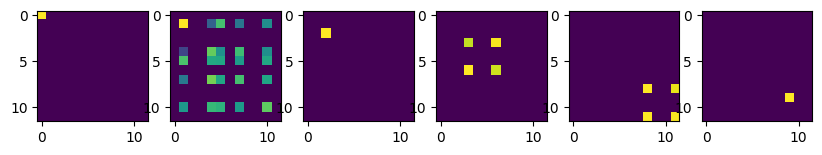

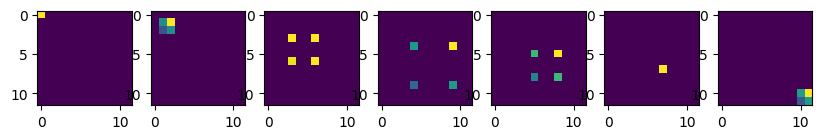

In [185]:
blocks = {} 


for j in range(len(Ms)): 
    blocks[j] = {} 
    plt.figure(figsize = (10, 10))
    for k in range(len(components[j])):
        plt.subplot(1, len(components[j]), k+1) 
        plt.imshow(extractor(MsMean[j],components[j][k]))
        blocks[j][k] = batch_extractor(Ms[j], components[j][k]) 



100%|██████████| 33/33 [00:02<00:00, 12.67it/s]


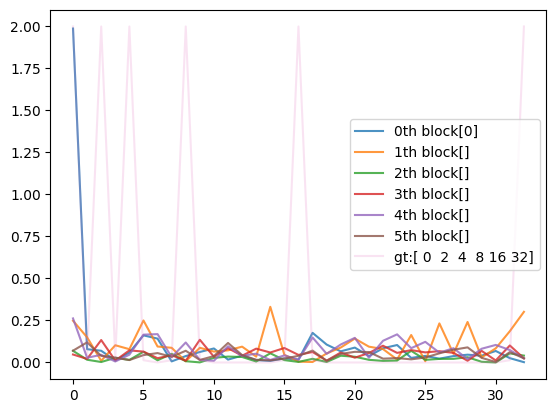

In [186]:
j = 0
plt.figure()
for k in range(len(blocks[j])): 
    targfreq, prods0 = ca.inner_prod(
        blocks[j][k].to(shifts.device), shifts, maxfreq=maxfreq, bins=maxfreq + 1
    )
    plt.plot(
        targfreq,
        prods0,
        label=f"""{k}th block"""  + str(np.where(prods0 > 1.0)[0]),
        alpha=0.8,
    )
plt.plot(
    targfreq,
    deltas,
    alpha=0.2,
    label="gt:" + str(np.where(deltas > 1.0)[0]),
)    
plt.legend() 

100%|██████████| 33/33 [00:02<00:00, 11.64it/s]


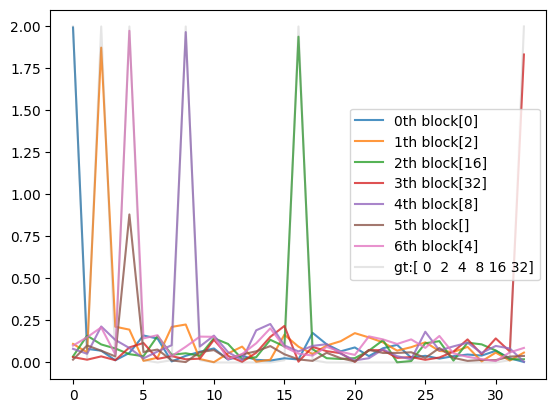

In [187]:
j = 1
plt.figure()
for k in range(len(blocks[j])): 
    targfreq, prods0 = ca.inner_prod(
        blocks[j][k].to(shifts.device), shifts, maxfreq=maxfreq, bins=maxfreq + 1
    )
    plt.plot(
        targfreq,
        prods0,
        label=f"""{k}th block"""  + str(np.where(prods0 > 1.0)[0]),
        alpha=0.8,
    )
plt.plot(
    targfreq,
    deltas,
    alpha=0.2,
    label="gt:" + str(np.where(deltas > 1.0)[0]),
)      
plt.legend() 

In [188]:
#Analysis of Top in terms of Low

components[0]


[[0], [1, 5, 4, 7, 10], [2], [3, 6], [8, 11], [9]]